In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
import sklearn
from sklearn.model_selection import train_test_split

CONEXION A BASE DE DATO

In [2]:
!wget -q https://github.com/velasquezjeisson/udem/raw/refs/heads/master/Proyecto%202/MateriasPrimasConsolidado.xlsx

In [3]:
df = pd.read_excel('~/MateriasPrimasConsolidado.xlsx', sheet_name='MateriasPrimasConsolidado', header=0, index_col=0)
df = df.dropna(axis=0, how='any')
df = df.dropna(axis=1, how='any')
df = df.drop(axis=1, labels=['Local_Timestamp','TimeStampDb','Partida','Solicitud','Valor_SP_Final','SP_Activo_Final','MateriaPrima','Equipo'])
df['Time_Stamp'] = pd.to_datetime(df['Time_Stamp'], dayfirst=True)
df.set_index('Time_Stamp', inplace=True)


df.head()

/tmp/ipykernel_27037/971501995.py:5: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S.%f format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Time_Stamp'] = pd.to_datetime(df['Time_Stamp'], dayfirst=True)


,PV_Final
Time_Stamp,
2024-11-28 00:33:00,1564.600590
2024-11-28 00:34:00,199.658432
2024-11-28 01:25:00,9.950685
2024-11-28 01:27:00,250.885925
2024-11-28 01:44:00,99.933740


In [4]:
df_diario = df.resample('D').sum()

Text(0.5, 1.0, 'Histograma de PV_Final (filtrado)')

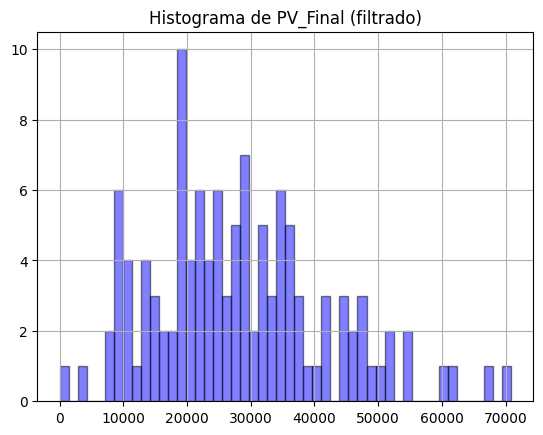

In [5]:
df_filtrado = df_diario[df_diario["PV_Final"] > 0]
df_filtrado["PV_Final"].hist(bins=50, alpha=0.5, color='blue', edgecolor='black')
plt.title('Histograma de PV_Final (filtrado)')

In [6]:
retardo = 10
for i in range(1, retardo+1):
    df_filtrado['PV_Final-'+str(i)] = df_filtrado['PV_Final'].shift(i)
df_filtrado.dropna(inplace=True)


/tmp/ipykernel_27037/3785396640.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['PV_Final-'+str(i)] = df_filtrado['PV_Final'].shift(i)
/tmp/ipykernel_27037/3785396640.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado['PV_Final-'+str(i)] = df_filtrado['PV_Final'].shift(i)
/tmp/ipykernel_27037/3785396640.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

In [7]:
X = df_filtrado.drop('PV_Final', axis=1)
y = df_filtrado['PV_Final']
X_train = X.iloc[:-30]
X_test = X.iloc[-30:]
y_train = y.iloc[:-30]
y_test = y.iloc[-30:]

In [8]:
import numpy as np

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)
X_train_log = np.log1p(X_train)
X_test_log = np.log1p(X_test)


In [9]:
from sklearn.metrics import mean_absolute_percentage_error

from sklearn.metrics import make_scorer


mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)


In [10]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_absolute_percentage_error

# Hiperparámetros para Gradient Boosting
param_distributions_gb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.7, 0.8, 1.0]
}

# Modelo base
gb = GradientBoostingRegressor(random_state=42)

# Búsqueda aleatoria con validación cruzada y MAPE
model_gb = RandomizedSearchCV(
    estimator=gb,
    param_distributions=param_distributions_gb,
    n_iter=30,  # puedes ajustar según el tiempo disponible
    scoring=mape_scorer,
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# Entrenar con la variable logarítmica
model_gb.fit(X_train_log, y_train_log)

# Mostrar resultados
print("Mejores parámetros:", model_gb.best_params_)
print(f"Score de validación cruzada (MAPE): {-model_gb.best_score_:.2f}%")
print(f"Score de entrenamiento (MAPE): {-model_gb.score(X_train_log, y_train_log):.2f}%")
print(f"Score de prueba (MAPE): {-model_gb.score(X_test_log, y_test_log):.2f}%")

# Predicción y evaluación en escala original
y_pred_gb_log = model_gb.predict(X_test_log)
y_pred_gb = np.expm1(y_pred_gb_log)

# MAPE real en escala original
mape_test_gb = mean_absolute_percentage_error(np.expm1(y_test_log), y_pred_gb)
print(f"MAPE real en prueba (escala original): {mape_test_gb * 100:.2f}%")


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Mejores parámetros: {'subsample': 0.7, 'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 3, 'learning_rate': 0.01}
Score de validación cruzada (MAPE): 0.06%
Score de entrenamiento (MAPE): 0.05%
Score de prueba (MAPE): 0.04%
MAPE real en prueba (escala original): 54.21%


In [11]:
import joblib

# Guardar el mejor modelo encontrado en el RandomizedSearchCV
joblib.dump(model_gb.best_estimator_, "modelo_gb.pkl")
# Cargar el modelo guardado

['modelo_gb.pkl']

In [12]:
import boto3
from dotenv import load_dotenv


load_dotenv(dotenv_path='conf.env')

# Obtener las credenciales de las variables de entorno
aws_access_key_id = os.getenv('AWS_ACCESS_KEY_ID')
aws_secret_access_key = os.getenv('AWS_SECRET_ACCESS_KEY')

# Inicializar cliente de S3
s3 = boto3.client('s3')

# Datos de tu bucket y nombre del archivo
bucket_name = 'udem-proyecto2'
s3_path = 'modelos/modelo_gb.pkl'

# Subida a S3
s3.upload_file('modelo_gb.pkl', bucket_name, s3_path)

print(f"Modelo subido a s3://{bucket_name}/{s3_path}")


Modelo subido a s3://udem-proyecto2/modelos/modelo_gb.pkl
